<a href="https://colab.research.google.com/github/Derrick-Majani/ReneWInd/blob/main/ReneWind_Project_Derrick_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ReneWind

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 40000 observations in the training set and 10000 in the test set.

The objective is to build various classification models, tune them and find the best one that will help identify failures so that the generator could be repaired before failing/breaking and the overall maintenance cost of the generators can be brought down. 

“1” in the target variables should be considered as “failure” and “0” will represent “No failure”.

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a wind turbine where there is no detection by model. 
- False positives (FP) are detections in a wind turbine where there is no failure. 

So, the maintenance cost associated with the model would be:

**Maintenance cost** = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`
where,

- `Replacement cost = $40,000`
- `Repair cost = $15,000`
- `Inspection cost = $5,000`

Here the objective is to reduce the maintenance cost so, we want a metric that could reduce the maintenance cost.

- The minimum possible maintenance cost  =  `Actual failures*(Repair cost) = (TP + FN)*(Repair cost)`
- The maintenance cost associated with model = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`

So, we will try to maximize the ratio of minimum possible maintenance cost and the maintenance cost associated with the model.

The value of this ratio will lie between 0 and 1, the ratio will be 1 only when the maintenance cost associated with the model will be equal to the minimum possible maintenance cost.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing libraries

In [ ]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np
import io
import os
import sys
import pandas_profiling
import seaborn as sns
sns.set(color_codes=True)
import warnings

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")



## Loading Data

In [ ]:
# Use Local drives to upload the csv on google colab
from google.colab import files
uploaded = files.upload()

Saving Train.csv to Train (1).csv


In [ ]:
# Loading the dataset
data = pd.read_csv(io.BytesIO(uploaded['Train.csv']))

In [ ]:
# Checking the number of rows and columns in the data
data.shape

(40000, 41)

## Data Overview

In [ ]:
# let's view the first 5 rows of the data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,-2.910,-2.569,4.109,1.317,-1.621,-3.827,-1.617,0.669,0.387,0.854,-6.353,4.272,3.162,0.258,-3.547,-4.285,2.897,1.508,3.668,7.124,-4.096,1.015,-0.970,-0.968,2.064,-1.646,0.427,0.735,-4.470,-2.772,-2.505,-3.783,-6.823,4.909,0.482,5.338,2.381,-3.128,3.527,-3.020,0
2,4.284,5.105,6.092,2.640,-1.041,1.308,-1.876,-9.582,3.470,0.763,-2.573,-3.350,-0.595,-5.247,-4.310,-16.232,-1.000,2.318,5.942,-3.858,-11.599,4.021,-6.281,4.633,0.930,6.280,0.851,0.269,-2.206,-1.329,-2.399,-3.098,2.690,-1.643,7.566,-3.198,-3.496,8.105,0.562,-4.227,0
3,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
4,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0


In [ ]:
# let's view the last 5 rows of the data
data.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
39995,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
39996,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
39997,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0
39998,0.521,0.096,8.457,2.138,-1.636,-2.713,-2.693,-3.410,1.936,2.012,-4.989,-0.819,4.166,-1.192,-5.033,-8.523,-1.950,0.017,4.505,2.031,-8.849,0.566,-6.040,-0.043,1.656,4.250,1.727,-1.686,-3.963,-2.642,1.939,-1.257,-1.136,1.434,5.905,3.752,-1.867,-1.918,2.573,-5.019,0
39999,2.403,-1.336,6.451,-5.356,-0.434,0.255,-1.120,-2.523,-0.654,2.316,-2.862,0.199,1.593,-0.337,-0.709,-4.408,-3.683,2.973,-1.223,-1.958,-4.454,0.464,-4.952,-1.624,2.965,2.009,5.712,-2.910,-2.287,-3.676,5.678,-4.310,-0.709,-1.359,1.639,7.766,-0.245,-1.124,2.872,1.902,0


In [ ]:
# let's check the data types of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      39954 non-null  float64
 1   V2      39961 non-null  float64
 2   V3      40000 non-null  float64
 3   V4      40000 non-null  float64
 4   V5      40000 non-null  float64
 5   V6      40000 non-null  float64
 6   V7      40000 non-null  float64
 7   V8      40000 non-null  float64
 8   V9      40000 non-null  float64
 9   V10     40000 non-null  float64
 10  V11     40000 non-null  float64
 11  V12     40000 non-null  float64
 12  V13     40000 non-null  float64
 13  V14     40000 non-null  float64
 14  V15     40000 non-null  float64
 15  V16     40000 non-null  float64
 16  V17     40000 non-null  float64
 17  V18     40000 non-null  float64
 18  V19     40000 non-null  float64
 19  V20     40000 non-null  float64
 20  V21     40000 non-null  float64
 21  V22     40000 non-null  float64
 22

We have a total of 41 variables with missing value on V1 and V2

In [ ]:
# let's check for duplicate values in the data
data.duplicated().sum()

0

In [ ]:
# let's check for missing values in the data
round(data.isnull().sum() / data.isnull().count() * 100, 2)

V1       0.120
V2       0.100
V3       0.000
V4       0.000
V5       0.000
V6       0.000
V7       0.000
V8       0.000
V9       0.000
V10      0.000
V11      0.000
V12      0.000
V13      0.000
V14      0.000
V15      0.000
V16      0.000
V17      0.000
V18      0.000
V19      0.000
V20      0.000
V21      0.000
V22      0.000
V23      0.000
V24      0.000
V25      0.000
V26      0.000
V27      0.000
V28      0.000
V29      0.000
V30      0.000
V31      0.000
V32      0.000
V33      0.000
V34      0.000
V35      0.000
V36      0.000
V37      0.000
V38      0.000
V39      0.000
V40      0.000
Target   0.000
dtype: float64

V1 has 0.12% missing values out of the total observations
V2 has 0.10% missing values out of the total observations 

In [ ]:
# Checking for the null value in the dataset
data.isna().sum()

V1        46
V2        39
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

**Let's check the number of unique values in each column**

In [ ]:
data.nunique()

V1        39954
V2        39961
V3        40000
V4        40000
V5        40000
V6        40000
V7        40000
V8        40000
V9        40000
V10       40000
V11       40000
V12       40000
V13       40000
V14       40000
V15       39999
V16       40000
V17       40000
V18       40000
V19       40000
V20       40000
V21       40000
V22       40000
V23       40000
V24       40000
V25       40000
V26       40000
V27       40000
V28       40000
V29       40000
V30       40000
V31       40000
V32       40000
V33       40000
V34       40000
V35       40000
V36       40000
V37       40000
V38       40000
V39       40000
V40       40000
Target        2
dtype: int64

In [ ]:
# let's view the statistical summary of the numerical columns in the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,39954.000,-0.288,3.449,-13.502,-2.751,-0.774,1.837,17.437
V2,39961.000,0.443,3.139,-13.212,-1.638,0.464,2.538,13.089
V3,40000.000,2.506,3.406,-11.469,0.203,2.265,4.585,18.366
V4,40000.000,-0.066,3.437,-16.015,-2.350,-0.124,2.149,13.280
V5,40000.000,-0.045,2.107,-8.613,-1.507,-0.097,1.346,9.403
V6,40000.000,-1.001,2.037,-10.227,-2.363,-1.007,0.374,7.065
V7,40000.000,-0.893,1.757,-8.206,-2.037,-0.935,0.207,8.006
V8,40000.000,-0.563,3.299,-15.658,-2.660,-0.384,1.714,11.679
V9,40000.000,-0.008,2.162,-8.596,-1.494,-0.052,1.426,8.507
V10,40000.000,-0.002,2.183,-11.001,-1.391,0.106,1.486,8.108


*** There is a large difference between the 3rd quartile and max value on almost all sensors V1 to V4o which could indicate possibilities of outliers

## EDA and insights

** Univariate Analysis

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="white"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Observation on Sensors

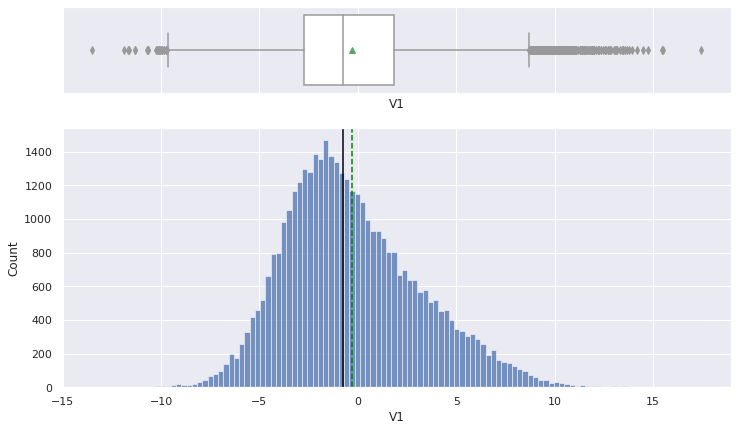

In [ ]:
# Observations on V1
histogram_boxplot(data, "V1")

*** Distribution seems to be Central with Outliers on both sides

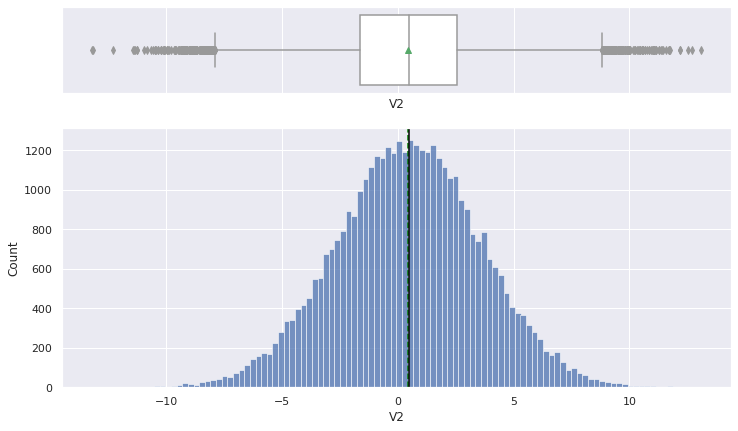

In [ ]:
# Observations on V2
histogram_boxplot(data, "V2")

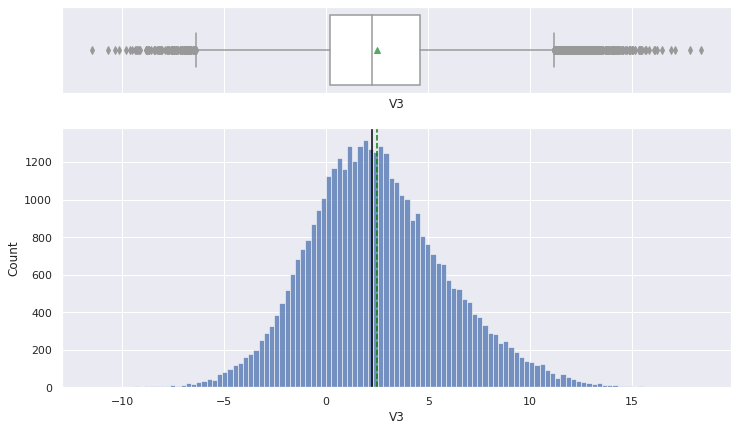

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V3")

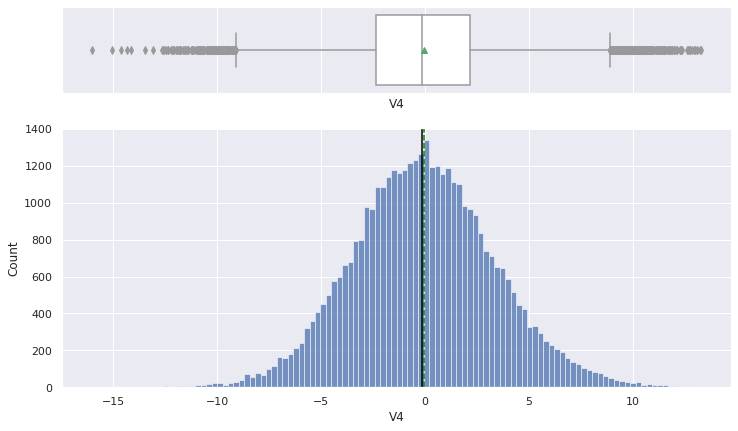

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V4")

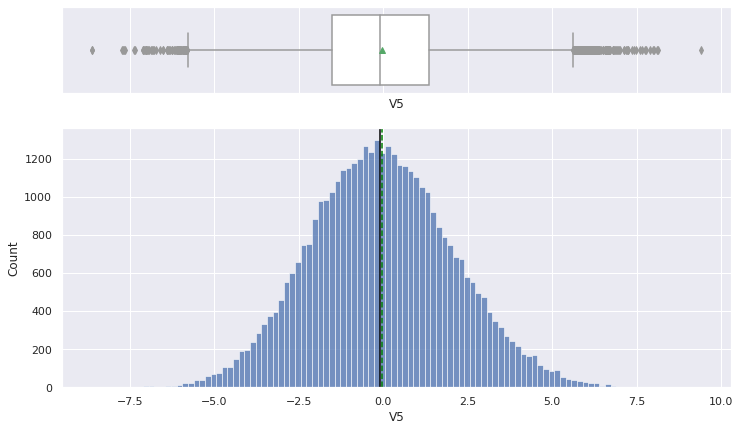

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V5")

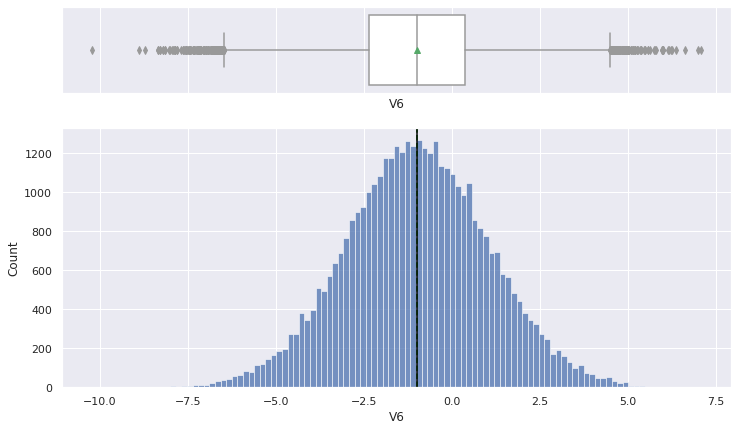

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V6")

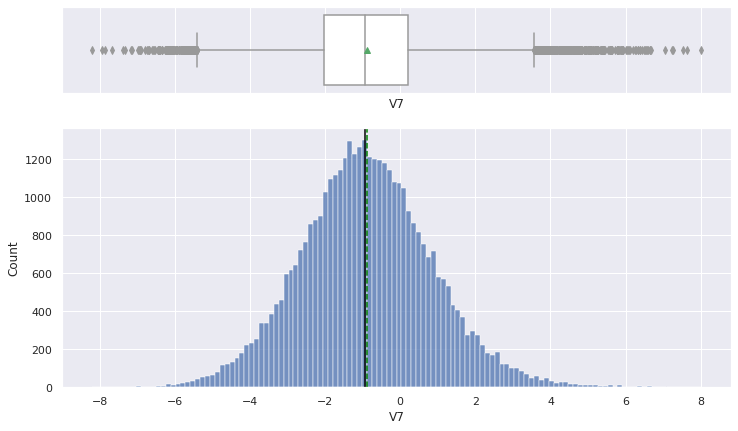

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V7")

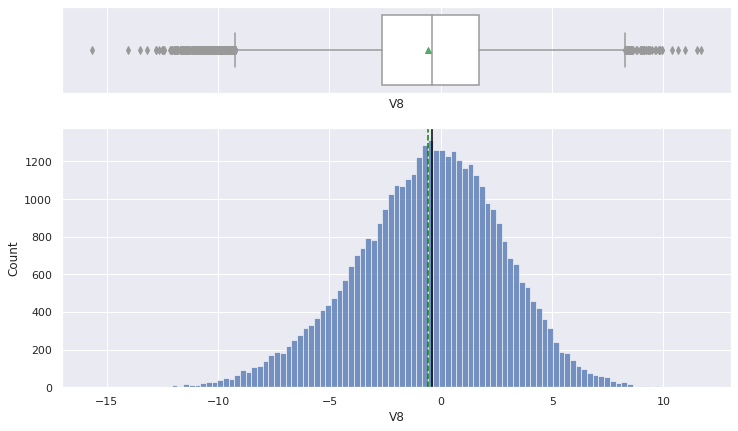

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V8")

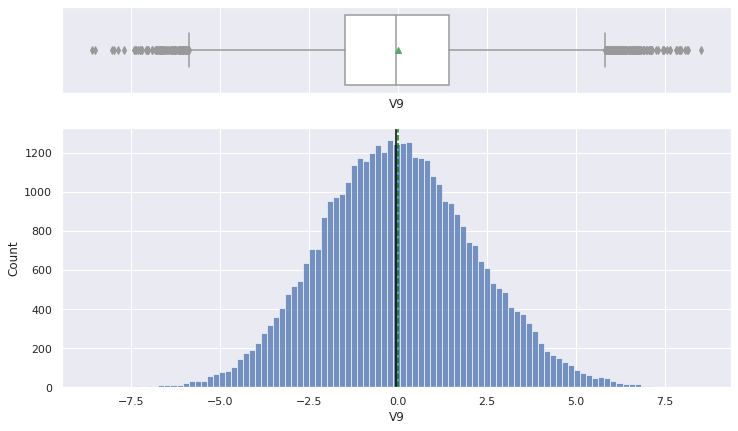

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V9")

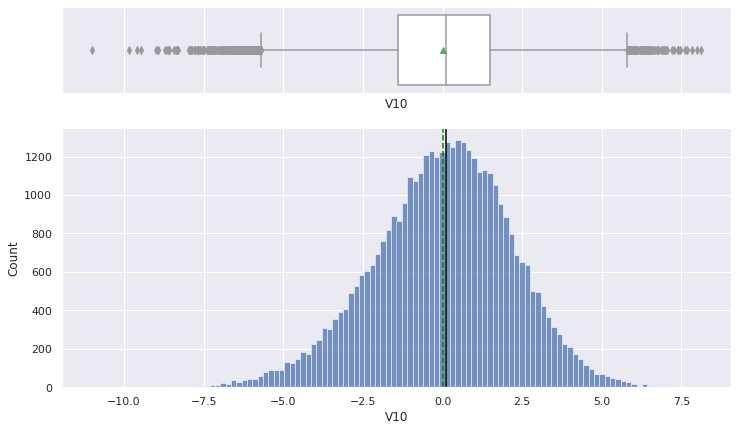

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V10")

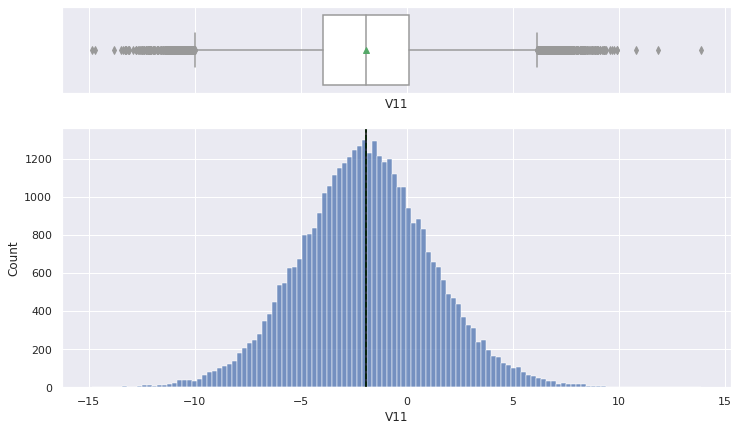

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V11")

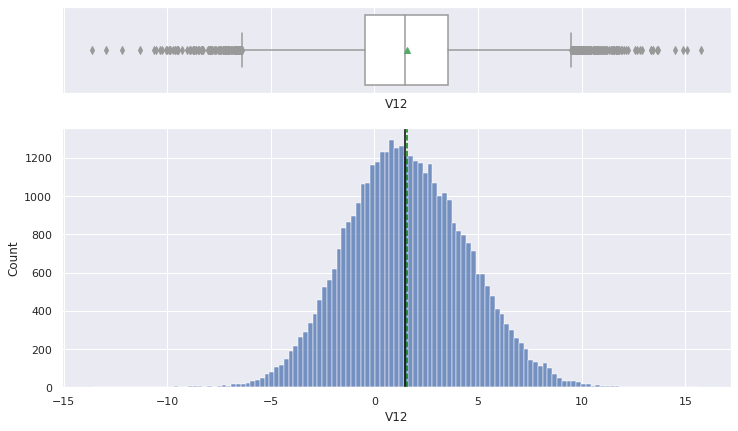

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V12")

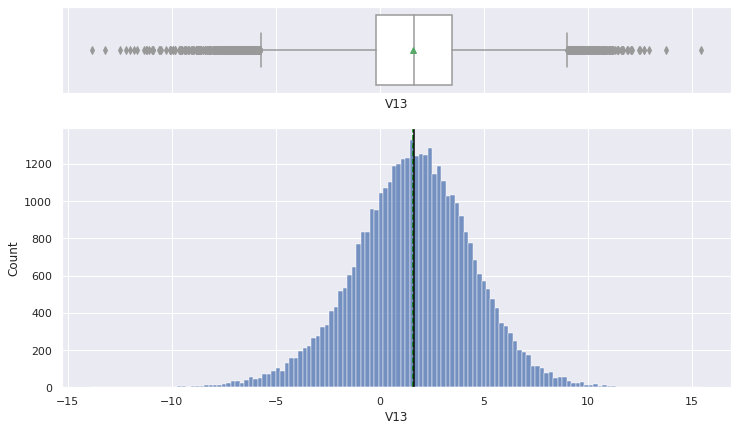

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V13")

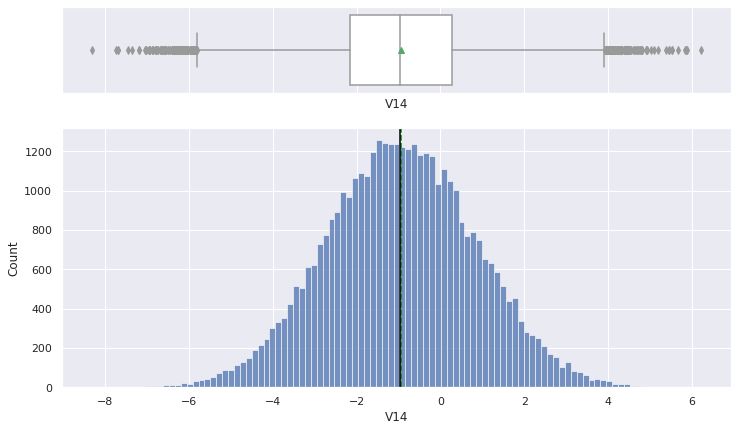

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V14")

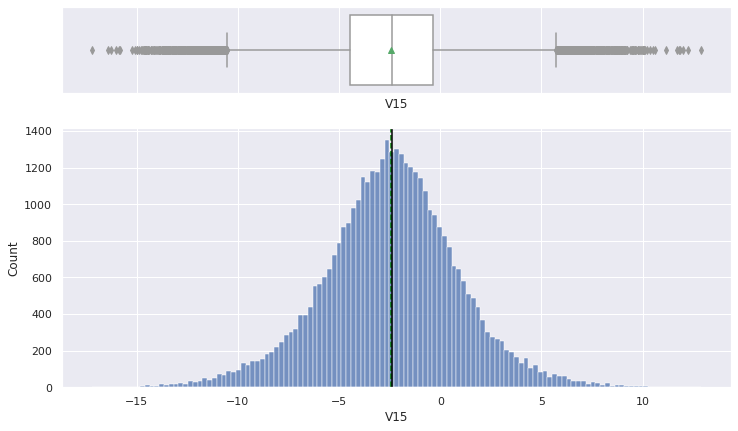

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V15")

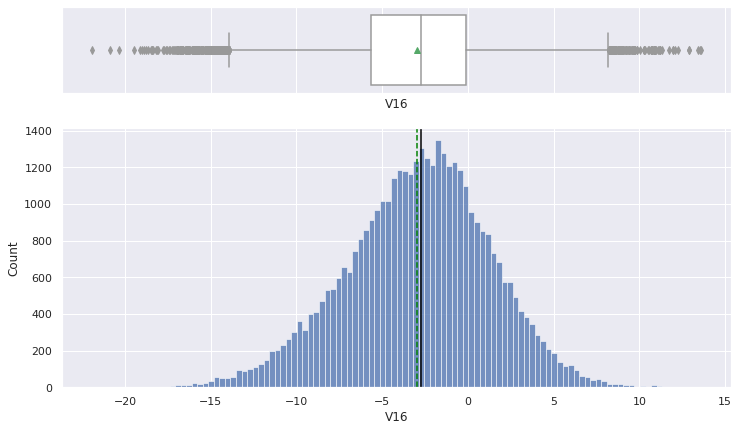

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V16")

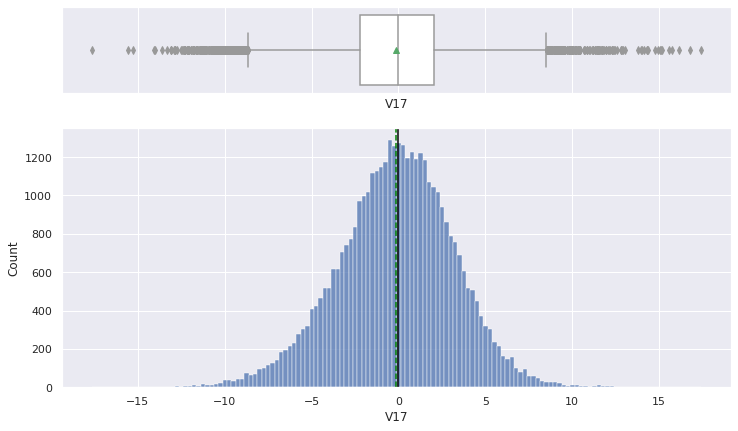

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V17")

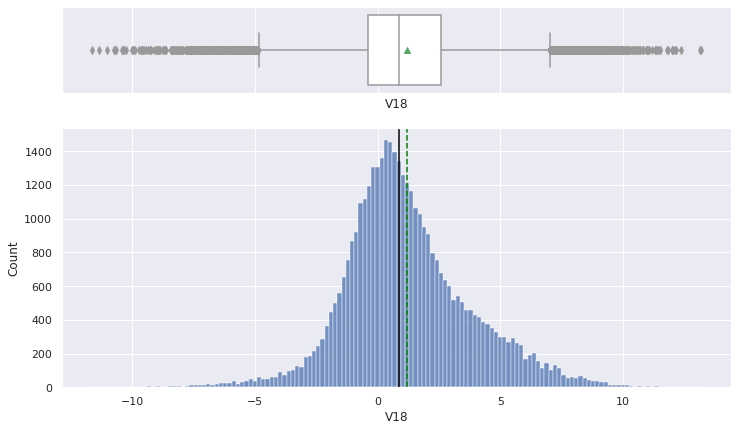

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V18")

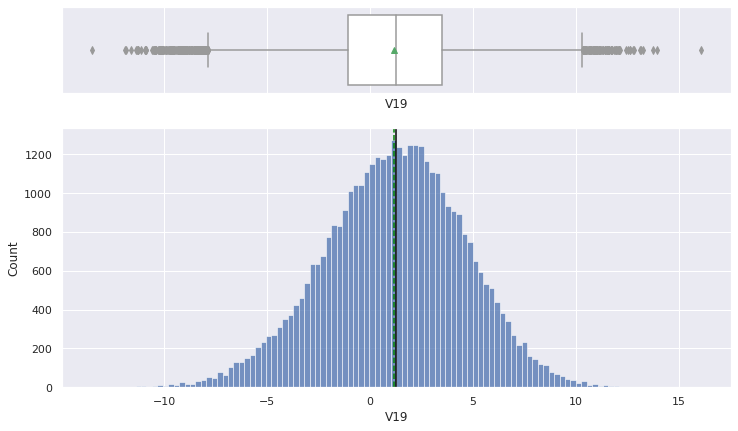

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V19")

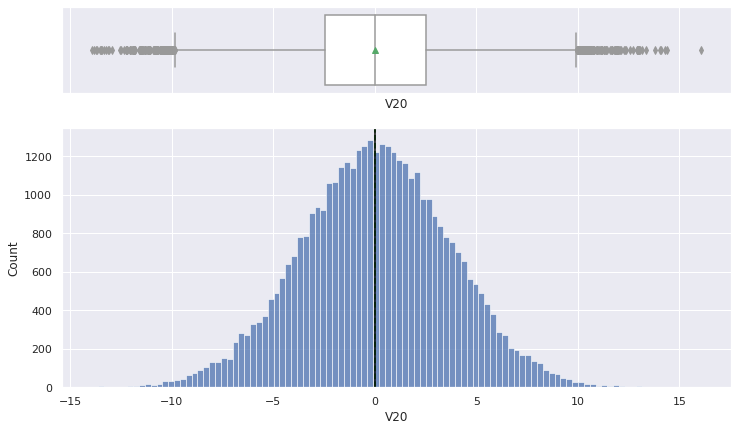

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V20")

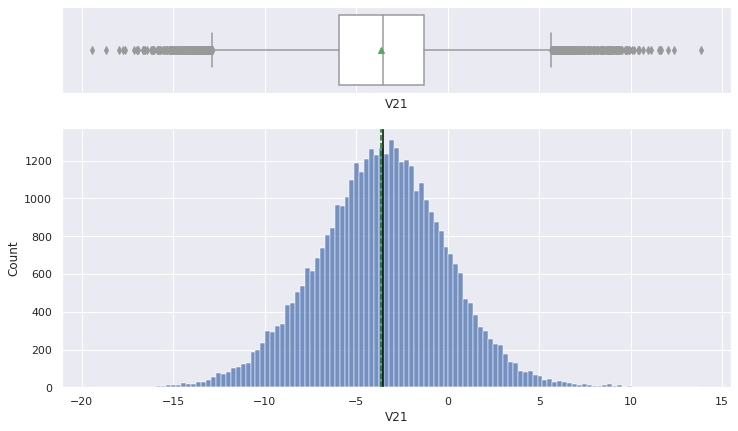

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V21")

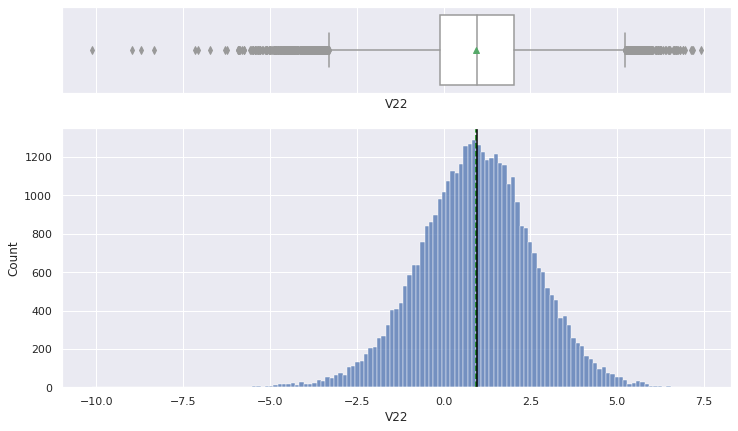

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V22")

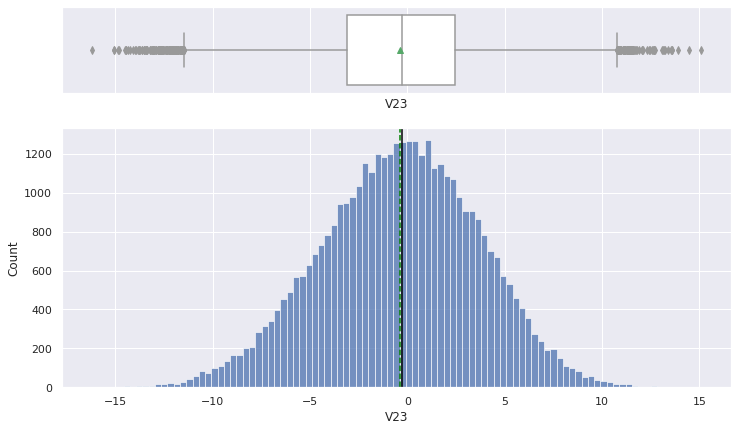

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V23")

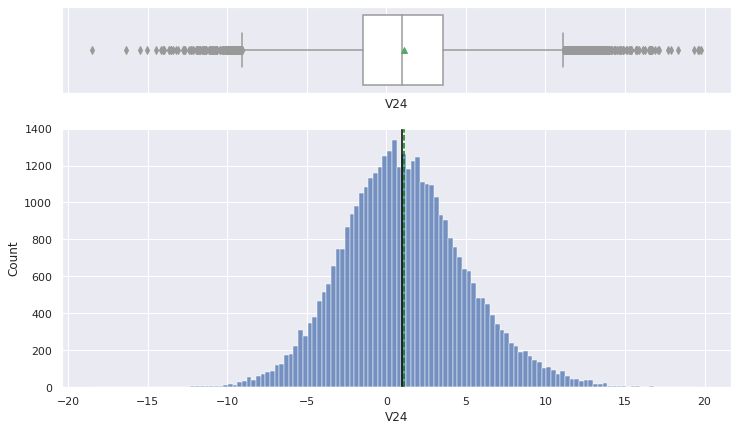

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V24")

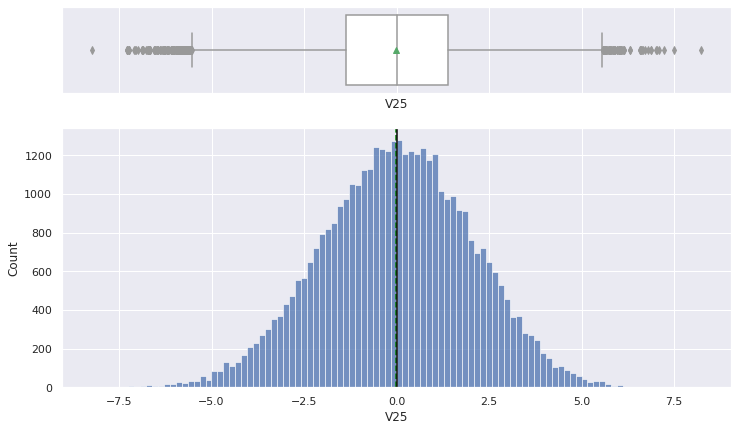

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V25")

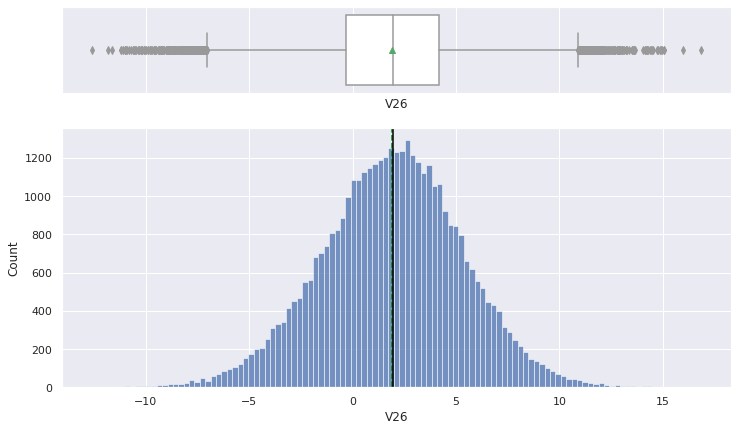

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V26")

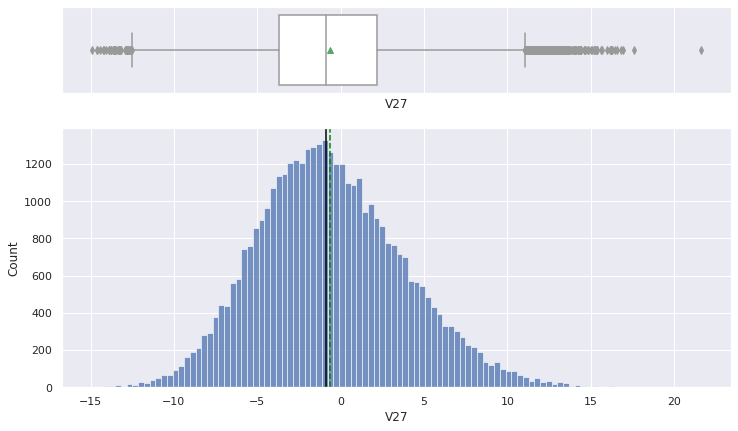

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V27")

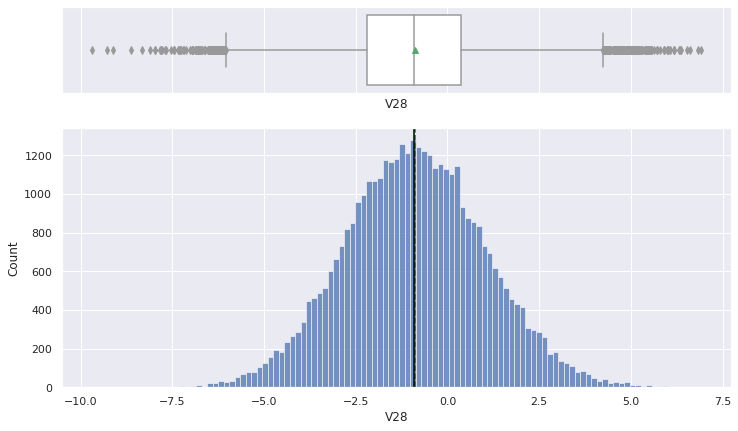

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V28")

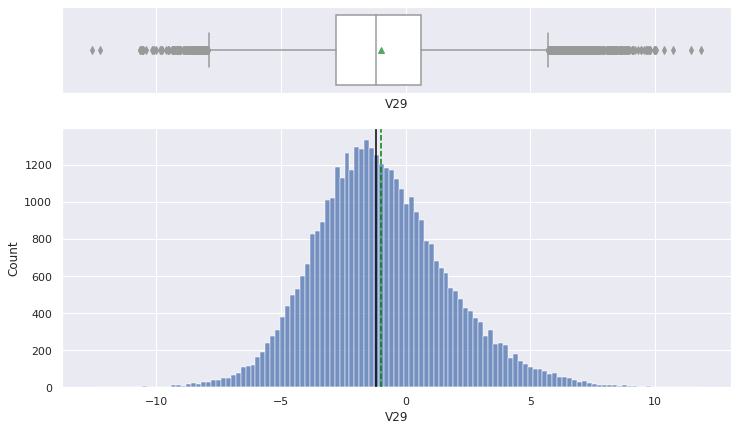

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V29")

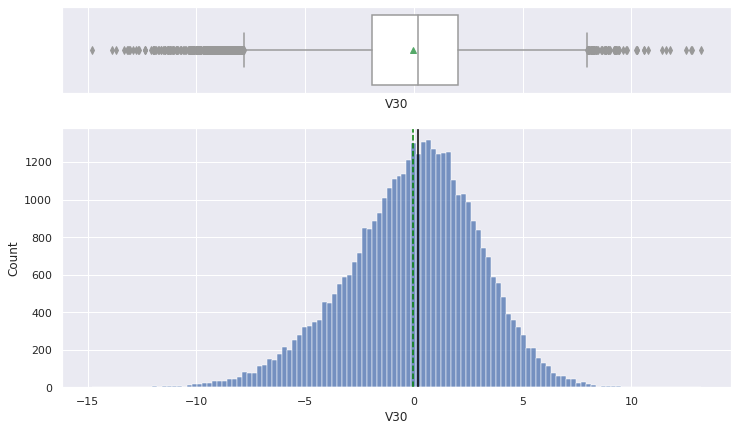

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V30")

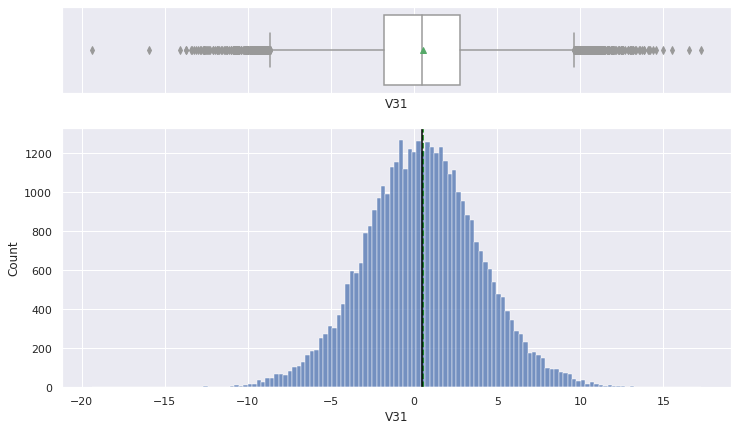

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V31")

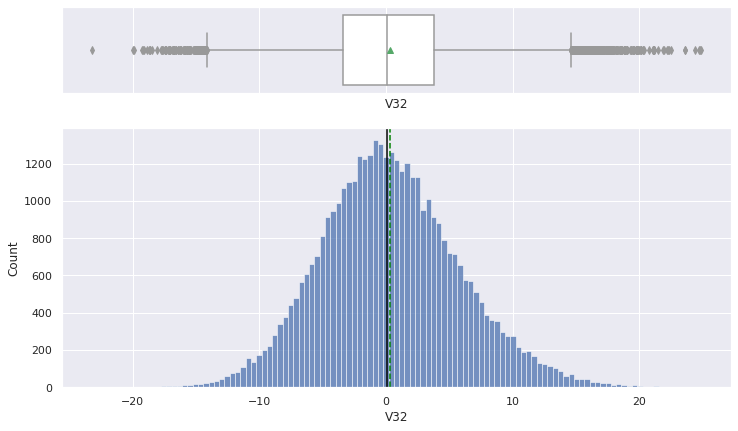

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V32")

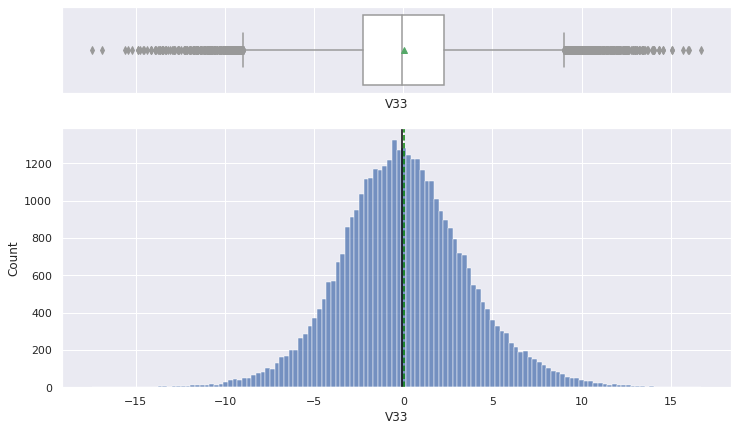

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V33")

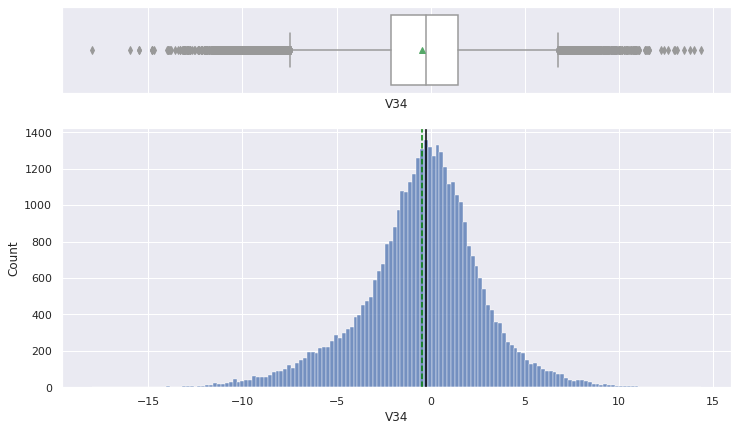

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V34")

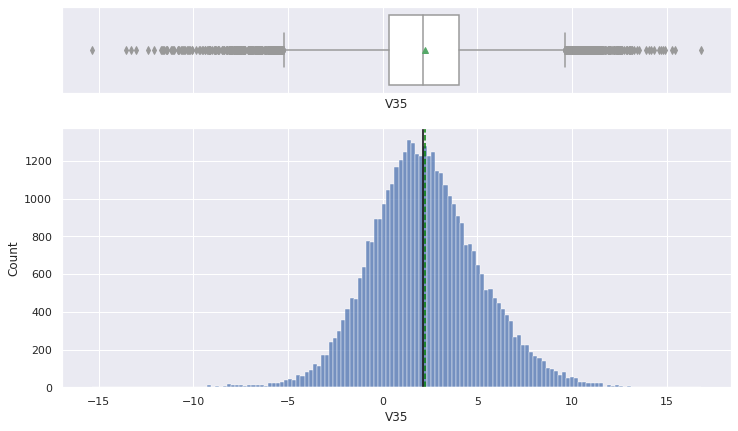

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V35")

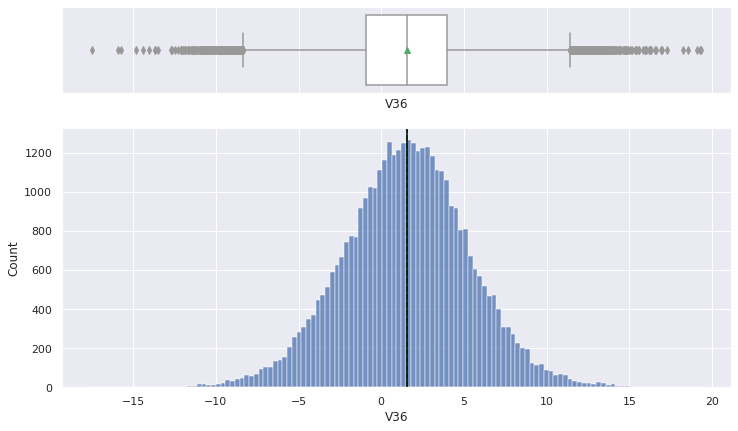

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V36")

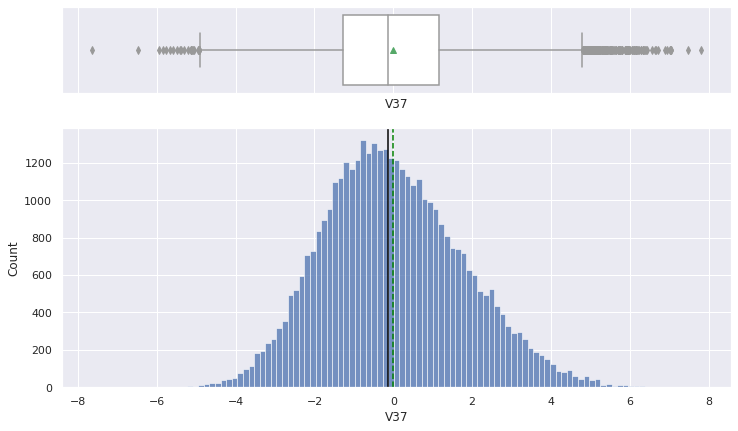

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V37")

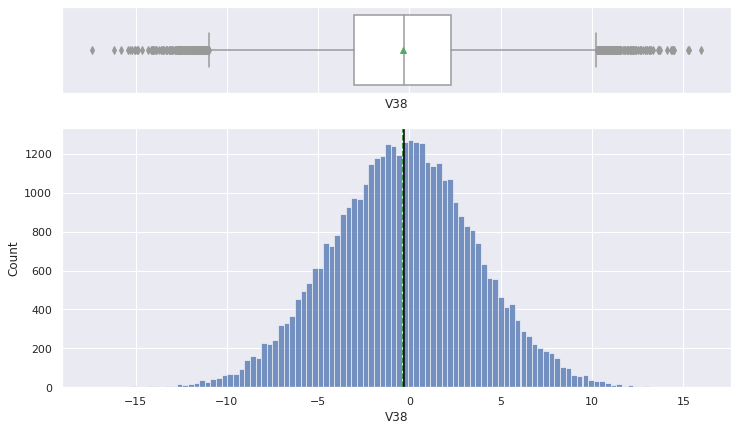

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V38")

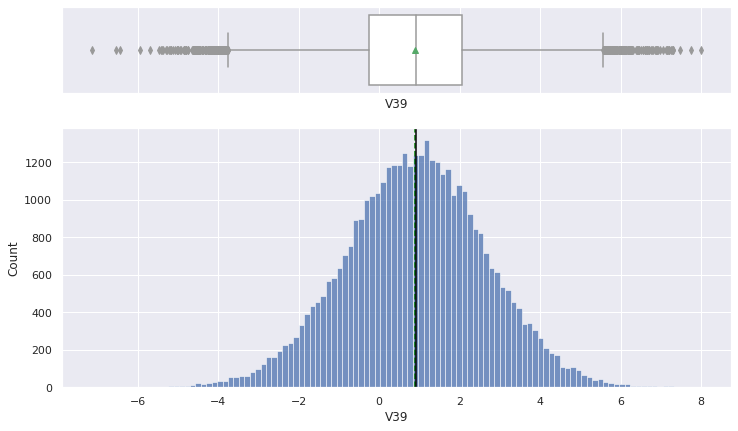

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V39")

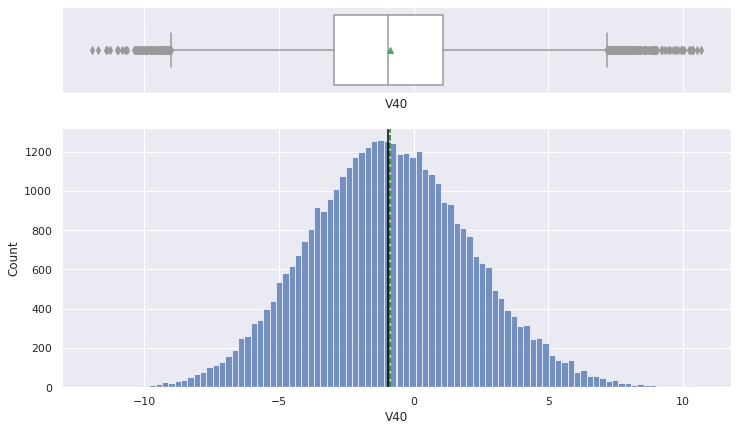

In [ ]:
# Observations on Sensors
histogram_boxplot(data, "V40")

** Outliers on all variables seems to be clipped so we shall not treat them
** Distributions of almost all the sensors seems to be normally distributed

### Observations on Target

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

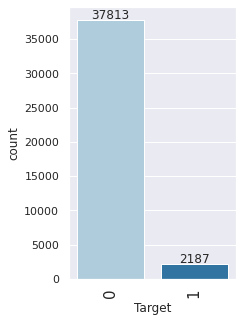

In [ ]:
# observations on Risk
labeled_barplot(data, "Target")

** The class distribution in the target variable is imbalanced.
** 2187 of the Total variables are failures and 37813 of the observations have no failure detection

## Bivariate Analysis

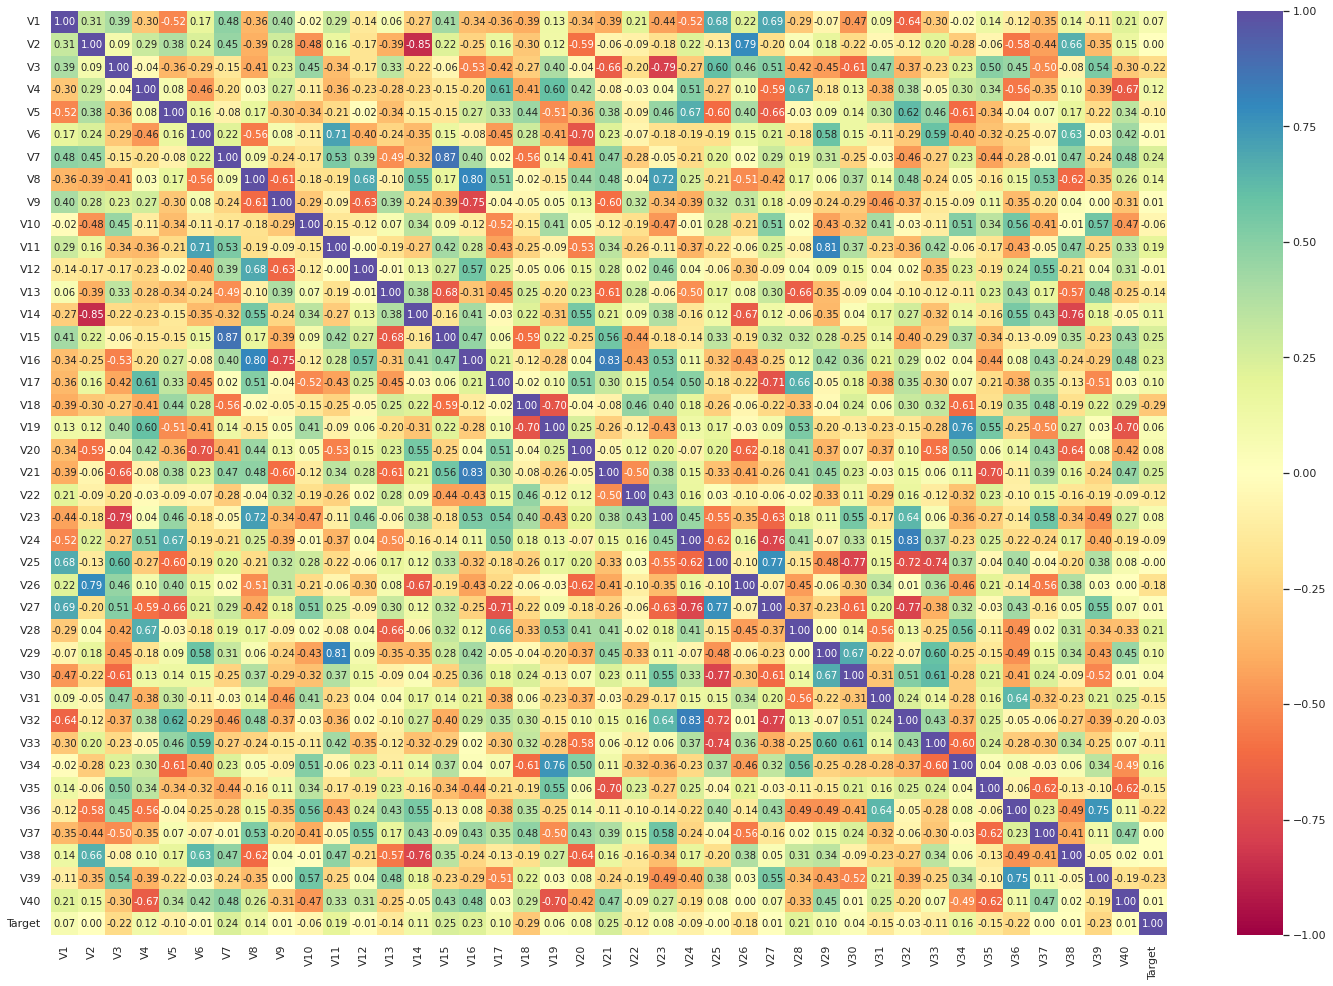

In [ ]:
plt.figure(figsize=(25, 17))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

** There is no significant correlation betwen the Target variables and other variables

## Data Pre-processing

### Split data

In [ ]:
df = data.copy()

### Data Preparation for Modeling

In [ ]:
X = df.drop(["Target"], axis=1)
X = pd.get_dummies(X)
y = df["Target"]

In [ ]:
# Splitting data into training, validation and test sets:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
   X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape)

(24000, 40) (8000, 40)


### Missing-Value Treatment

In [ ]:
# Let's impute the missing values
imp_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
cols_to_impute = ['V1','V2','V3']

# fit and transform the imputer on train data
X_train[cols_to_impute] = imp_mode.fit_transform(X_train[cols_to_impute])

# Transform on validation and test data
X_val[cols_to_impute] = imp_mode.transform(X_val[cols_to_impute])

# fit and transform the imputer on test data
X_test[cols_to_impute] = imp_mode.transform(X_test[cols_to_impute])

In [ ]:
# Creating dummy variables for categorical variables
X_train = pd.get_dummies(data=X_train, drop_first=True)
X_val = pd.get_dummies(data=X_val, drop_first=True)


## Model evaluation criterion

### 3 types of cost are associated with the provided problem
1. Replacement cost - False Negatives - Predicting no failure, while there will be a failure
2. Inspection cost - False Positives - Predicting failure, while there is no failure 
3. Repair cost - True Positives - Predicting failure correctly

### How to reduce the overall cost?
* We need to create a customized metric, that can help to bring down the overall cost.
* The cost associated with any model = TP * 15000 + FP * 5000 + FN * 40000
* And the minimum possible cost will be when, the model will be able to identify all failures, in that case, the cost will be (TP + FN) * 15000
* So, we will try to maximize `Minimum cost/Cost associated with model`

**Let's create two functions to calculate different metrics and confusion matrix, so that we don't have to use the same code repeatedly for each model.**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    TP = confusion_matrix(target, model.predict(predictors))[1, 1]
    FP = confusion_matrix(target, model.predict(predictors))[0, 1]
    FN = confusion_matrix(target, model.predict(predictors))[1, 0]
    Cost = TP * 15 + FP * 5 + FN * 40  # maintenance cost by using model
    Min_Cost = (TP + FN) * 15  # minimum possible maintenance cost = number of actual positives
    Percent = Min_Cost / Cost  # ratio of minimum possible maintenance cost and maintenance cost by model

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            "Minimum_Vs_Model_cost": Percent,
        },
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Decision Tree Model

In [ ]:
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

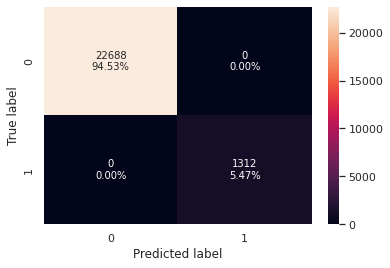

In [ ]:
confusion_matrix_sklearn(model, X_train, y_train)

In [ ]:
decision_tree_perf_train = model_performance_classification_sklearn(
    model, X_train, y_train
)
decision_tree_perf_train

,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,1.000,1.000,1.000,1.000,1.000


- 0 errors on the training set, each sample has been classified correctly.
- Model has performed very well on the training set.

#### Checking model performance on validation set

In [ ]:
decision_tree_val_test = model_performance_classification_sklearn(
    model, X_val, y_val
)
decision_tree_val_test

,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.970,0.776,0.700,0.736,0.674


- The decision tree model is overfitting the data as expected and not able to generalize well on the test set.

### Random Forest Classifier

In [ ]:
#Train the random forest classifier
rf_estimator=RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [ ]:
# Calculating different metrics
rf_estimator_model_train_perf = model_performance_classification_sklearn(
    rf_estimator, X_train, y_train
)
rf_estimator_model_train_perf

,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,1.000,0.999,1.000,1.000,0.999


* MOdel performing well 

#### Checking model performance on Validation

In [ ]:
rf_estimator_model_val_perf = model_performance_classification_sklearn(
    rf_estimator, X_val, y_val
)
rf_estimator_model_val_perf

,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.988,0.795,0.986,0.880,0.743


* Model overfitting on test 

### Bagging Classifier

In [ ]:
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train, y_train)

BaggingClassifier(random_state=1)

#### Checking model performance on training set

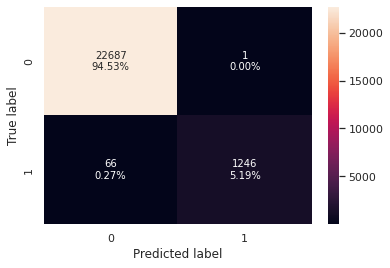

In [ ]:
confusion_matrix_sklearn(bagging_classifier, X_train, y_train)

In [ ]:
bagging_classifier_model_train_perf = model_performance_classification_sklearn(
    bagging_classifier, X_train, y_train
)
bagging_classifier_model_train_perf

,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.997,0.950,0.999,0.974,0.922


* Model overfitting on training 

#### Checking model performance on Validation

In [ ]:
# Calculating different metrics on validation set
bagging_classifier_model_val_perf = model_performance_classification_sklearn(
    bagging_classifier, X_val, y_val
)
print("Validation performance:")
bagging_classifier_model_val_perf


Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.985,0.774,0.947,0.852,0.719


* Model performing poorly as compared to training

### Logistic Regression 

In [ ]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [ ]:
# Calculating different metrics on train set
log_reg_model_train_perf = model_performance_classification_sklearn(
    lr, X_train, y_train
)
print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.967,0.478,0.857,0.614,0.527


In [ ]:
# Calculating different metrics on validation set
log_reg_model_val_perf = model_performance_classification_sklearn(lr, X_val, y_val)
print("Validation performance:")
log_reg_model_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.967,0.523,0.798,0.632,0.544


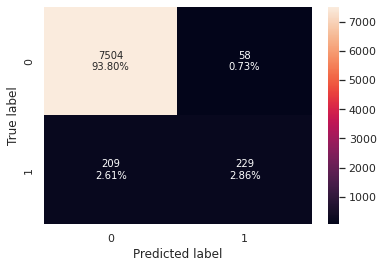

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(lr, X_val, y_val)

### AdaBoost Classifier

In [ ]:
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train, y_train)

AdaBoostClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
abc_model_train_perf = model_performance_classification_sklearn(
    ab_classifier, X_train, y_train
)
print("Training performance:")
abc_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.976,0.625,0.900,0.738,0.607


In [ ]:
# Calculating different metrics on validation set
abc_model_val_perf = model_performance_classification_sklearn(
    ab_classifier, X_val, y_val
)
print("Validation performance:")
abc_model_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.974,0.623,0.869,0.726,0.603


Model not performing well on validation

### Gradient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
gbc_model_train_perf = model_performance_classification_sklearn(
    gbc, X_train, y_train
)
print("Training performance:")
gbc_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.987,0.779,0.978,0.867,0.728


In [ ]:
# Calculating different metrics on validation set
gbc_model_val_perf = model_performance_classification_sklearn(
    gbc, X_val, y_val
)
print("Validation performance:")
gbc_model_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.983,0.751,0.932,0.832,0.698


* Model performing better in training as compared to validation

### XGBoost Classifier

In [ ]:
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(X_train,y_train)

XGBClassifier(eval_metric='logloss', random_state=1)

In [ ]:
# Calculating different metrics on train set
xgb_model_train_perf = model_performance_classification_sklearn(
    xgb, X_train, y_train
)
print("Training performance:")
xgb_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.989,0.805,0.985,0.886,0.752


In [ ]:
# Calculating different metrics on Validation set
xgb_model_val_perf = model_performance_classification_sklearn(
    xgb, X_val, y_val
)
print("Validation performance:")
xgb_model_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.987,0.788,0.969,0.869,0.734


* Model still overfitting on both training and validation

## **Defining scorer to be used for hyperparameter tuning**

- Every prediction of a classification model will be either a TP, FP, FN or TN.
- Till now at most of the places we wanted to reduce False negatives and hence we tried to maximize "Recall".
- To maximize Recall, we used Recall as a **scorer** in hyperparameter tuning.
- Here, we not only want to minimize false negatives but also false positives and we are also given the costs associated with each type of prediction.
- So, overall we want to reduce the maintenance cost which is: `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`
- In simple language, we can say that we are assigning different weightage to the different types of predictions.
- Do we have any such metric which can help us minimize the maintenance cost? i.e., help us reduce FP and FN as per the weightage - We don't have any such inbuilt metric.
- In sklearn, we can define **custom scorers** also as per our need.
- For this classification problem, we need to reduce the maintenance cost, which can be reiterated as:
  - Minimize (maintenance cost)
  - Maximize (1/maintenance cost)
  - Maximize (minimum possible maintenance cost/maintenance cost)
- Eventually, all 3 metrics will do the same work in the backend and the only difference will be in the scale of the values of the metric.

- The metric provided in the next cell is to `maximize(minimum possible maintenance cost/maintenance cost)`
- You can modify the metric as per convenience and use it further to tune the models.

In [ ]:
# defining metric to be used for optimization and with cross-validation
def Minimum_Vs_Model_cost(y_train, y_pred):
    """
    We want the model to optimize the maintenance cost and reduce it to the lowest possible value.
    The lowest possible maintenance cost will be achieved when each sample is predicted correctly.

    In such a scenario, the maintenance cost will be the total number of failures times the maintenance cost of replacing one generator,
    which is given by (TP + FN) * 40 (i.e., the actual positives*40).
    For any other scenario,
    the maintenance cost associated with the model will be given by (TP * 15 + FP * 5 + FN * 40).

    We will use the ratio of these two maintenance costs as the cost function for our model.
    The greater the ratio, the lower the associated maintenance cost and the better the model.
    """
    TP = confusion_matrix(y_train, y_pred)[1, 1]
    FP = confusion_matrix(y_train, y_pred)[0, 1]
    FN = confusion_matrix(y_train, y_pred)[1, 0]
    return ((TP + FN) * 15) / (TP * 15 + FP * 5 + FN * 40)


# A value of .80 here, will represent that the minimum maintenance cost is 80% of the maintenance cost associated with the model.
# Since minimum maintenance cost is constant for any data, when minimum cost will become 100% of maintenance cost associated with the model
# Model will have give the least possible maintenance cost.


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Higher the values, the lower the maintenance cost

## Model Building with Oversampled data


In [ ]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [ ]:
print("Before Oversampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print("After Oversampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label '1': 1312
Before Oversampling, counts of label '0': 22688 

After Oversampling, counts of label '1': 22688
After Oversampling, counts of label '0': 22688 

After Oversampling, the shape of train_X: (45376, 40)
After Oversampling, the shape of train_y: (45376,) 



### Decision Tree on oversampled data

In [ ]:
dtree_reg_over = DecisionTreeClassifier(random_state=1)

# Training the basic logistic regression model with training set
dtree_reg_over.fit(X_train_over, y_train_over)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
dtree_reg_over_train_perf = model_performance_classification_sklearn(
    dtree_reg_over, X_train_over, y_train_over
)
print("Training performance:")
dtree_reg_over_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,1.000,1.000,1.000,1.000,1.000


In [ ]:
# Calculating different metrics on validation set
dtree_reg_over_val_perf = model_performance_classification_sklearn(
    dtree_reg_over, X_val, y_val
)
print("validation performance:")
dtree_reg_over_val_perf

validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.949,0.820,0.523,0.639,0.645


* Model performing well on training but poorly on validation set

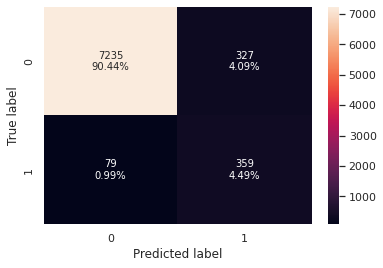

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(dtree_reg_over, X_val, y_val)

### Random Forest on oversampled data

In [ ]:
rf_reg_over = RandomForestClassifier(random_state=1)

# Training the basic logistic regression model with training set
rf_reg_over.fit(X_train_over, y_train_over)

RandomForestClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
rf_reg_over_train_perf = model_performance_classification_sklearn(
    rf_reg_over, X_train_over, y_train_over
)
print("Training performance:")
rf_reg_over_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,1.000,1.000,1.000,1.000,1.000


In [ ]:
# Calculating different metrics on validation set
rf_reg_over_val_perf = model_performance_classification_sklearn(
    rf_reg_over, X_val, y_val
)
print("validation performance:")
rf_reg_over_val_perf

validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.989,0.879,0.917,0.897,0.814


* Performance on the training set improved but the model is not able to replicate the same for the validation set.

* Model is overfitting.

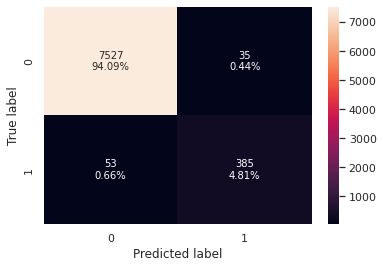

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(rf_reg_over, X_val, y_val)

### Bagging Classifier on oversampled data

In [ ]:
bg_reg_over = BaggingClassifier(random_state=1)

# Training the basic logistic regression model with training set
bg_reg_over.fit(X_train_over, y_train_over)

BaggingClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
bg_reg_over_train_perf = model_performance_classification_sklearn(
    bg_reg_over, X_train_over, y_train_over
)
print("Training performance:")
bg_reg_over_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.999,0.999,1.000,0.999,0.998


In [ ]:
# Calculating different metrics on validation set
bg_reg_over_val_perf = model_performance_classification_sklearn(
    bg_reg_over, X_val, y_val
)
print("validation performance:")
bg_reg_over_val_perf

validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.980,0.833,0.808,0.820,0.744


* Model performing well on Precison in training but overfitting in the other models on both training and validation sets

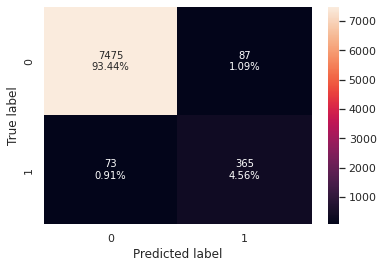

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(bg_reg_over, X_val, y_val)

### Logistic Regression on oversampled data

In [ ]:
log_reg_over = LogisticRegression(random_state=1)

# Training the basic logistic regression model with training set
log_reg_over.fit(X_train_over, y_train_over)

LogisticRegression(random_state=1)

In [ ]:
# Calculating different metrics on train set
log_reg_over_train_perf = model_performance_classification_sklearn(
    log_reg_over, X_train_over, y_train_over
)
print("Training performance:")
log_reg_over_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.872,0.874,0.871,0.872,0.798


In [ ]:
# Calculating different metrics on validation set
log_reg_over_val_perf = model_performance_classification_sklearn(
    log_reg_over, X_val, y_val
)
print("validation performance:")
log_reg_over_val_perf

validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.868,0.863,0.275,0.417,0.503


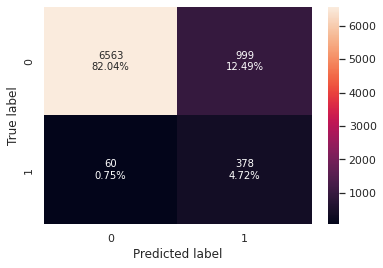

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(log_reg_over, X_val, y_val)

* Performance on the training set improved but the model is not able to replicate the same for the validation set.

* Model is overfitting.

### Ada Boost on oversampled data

In [ ]:
ab_reg_over = AdaBoostClassifier(random_state=1)

# Training the basic logistic regression model with training set
ab_reg_over.fit(X_train_over, y_train_over)

AdaBoostClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
ab_reg_over_train_perf = model_performance_classification_sklearn(
    ab_reg_over, X_train_over, y_train_over
)
print("Training performance:")
ab_reg_over_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.906,0.892,0.918,0.905,0.829


In [ ]:
# Calculating different metrics on validation set
ab_reg_over_val_perf = model_performance_classification_sklearn(
    ab_reg_over, X_val, y_val
)
print("validation performance:")
ab_reg_over_val_perf

validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.915,0.884,0.380,0.531,0.597


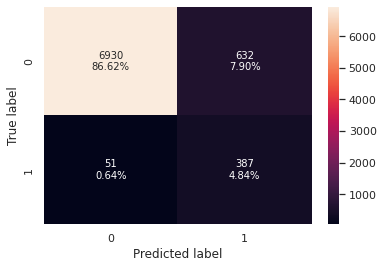

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(ab_reg_over, X_val, y_val)

* Model overfitting in both training and validation

### Gradient Boost on oversampled data

In [ ]:
gbc_reg_over = GradientBoostingClassifier(random_state=1)

# Training the basic logistic regression model with training set
gbc_reg_over.fit(X_train_over, y_train_over)

GradientBoostingClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
gbc_reg_over_train_perf = model_performance_classification_sklearn(
    gbc_reg_over, X_train_over, y_train_over
)
print("Training performance:")
gbc_reg_over_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.949,0.925,0.971,0.947,0.882


In [ ]:
# Calculating different metrics on validation set
gbc_reg_over_val_perf = model_performance_classification_sklearn(
    gbc_reg_over, X_val, y_val
)
print("validation performance:")
gbc_reg_over_val_perf

validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.960,0.904,0.589,0.714,0.730


* Model still overfitting in both models

### XGBoost on oversampled data

In [ ]:
xgb_reg_over = XGBClassifier(random_state=1,eval_metric='logloss')

# Training the basic logistic regression model with training set
xgb_reg_over.fit(X_train_over, y_train_over)

XGBClassifier(eval_metric='logloss', random_state=1)

In [ ]:
# Calculating different metrics on train set
xgb_reg_over_train_perf = model_performance_classification_sklearn(
    xgb_reg_over, X_train_over, y_train_over
)
print("Training performance:")
xgb_reg_over_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.947,0.921,0.972,0.946,0.876


In [ ]:
# Calculating different metrics on validation set
xgb_reg_over_val_perf = model_performance_classification_sklearn(
    xgb_reg_over, X_val, y_val
)
print("validation performance:")
xgb_reg_over_val_perf

validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.960,0.895,0.590,0.711,0.724


* Model still overfitting in both training and validation sets

## Model Building with Undersampled data

In [ ]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print("After Undersampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After Undersampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))

print("After Undersampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Undersampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Undersampling, counts of label '1': 1312
Before Undersampling, counts of label '0': 22688 

After Undersampling, counts of label '1': 1312
After Undersampling, counts of label '0': 1312 

After Undersampling, the shape of train_X: (2624, 40)
After Undersampling, the shape of train_y: (2624,) 



### Decision Tree on undersampled data

In [ ]:
dtree_reg_under = DecisionTreeClassifier(random_state=1)
dtree_reg_under.fit(X_train_un, y_train_un)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
dtree_reg_under_train_perf = model_performance_classification_sklearn(
    dtree_reg_under, X_train_un, y_train_un
)
print("Training performance:")
dtree_reg_under_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,1.000,1.000,1.000,1.000,1.000


In [ ]:
# Calculating different metrics on validation set
dtree_reg_under_val_perf = model_performance_classification_sklearn(
    dtree_reg_under, X_val, y_val
)
print("Validation performance:")
dtree_reg_under_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.847,0.884,0.248,0.388,0.480


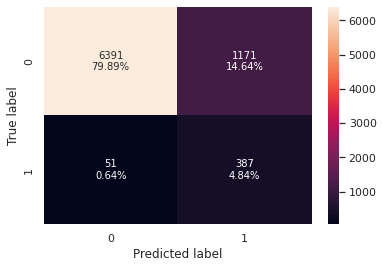

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(dtree_reg_under, X_val, y_val)

* Model performing well in training but overfitting in validation

### Random Forest on undersampled data

In [ ]:
rf_reg_under = RandomForestClassifier(random_state=1)
rf_reg_under.fit(X_train_un, y_train_un)

RandomForestClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
rf_reg_under_train_perf = model_performance_classification_sklearn(
    rf_reg_under, X_train_un, y_train_un
)
print("Training performance:")
rf_reg_under_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,1.000,1.000,1.000,1.000,1.000


In [ ]:
# Calculating different metrics on validation set
rf_reg_under_val_perf = model_performance_classification_sklearn(
    rf_reg_under, X_val, y_val
)
print("Validation performance:")
rf_reg_under_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.961,0.902,0.591,0.714,0.729


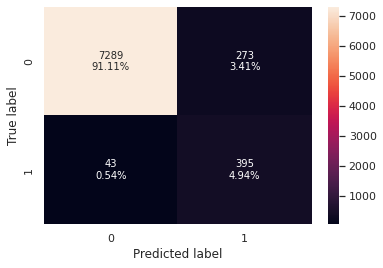

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(rf_reg_under, X_val, y_val)

* Model overfitting in validation set and performing well in training 

### Bagging Classifier on undersampled data

In [ ]:
bg_reg_under = BaggingClassifier(random_state=1)
bg_reg_under.fit(X_train_un, y_train_un)

BaggingClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
bg_reg_under_train_perf = model_performance_classification_sklearn(
    bg_reg_under, X_train_un, y_train_un
)
print("Training performance:")
bg_reg_under_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.990,0.982,0.998,0.990,0.971


In [ ]:
# Calculating different metrics on validation set
bg_reg_under_val_perf = model_performance_classification_sklearn(
    bg_reg_under, X_val, y_val
)
print("Validation performance:")
bg_reg_under_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.950,0.879,0.524,0.656,0.681


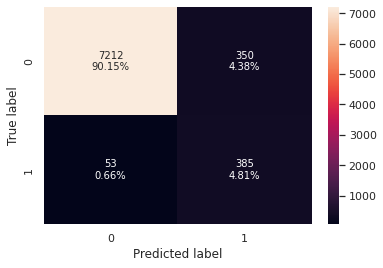

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(bg_reg_under, X_val, y_val)

* Model overfitting in both training and validation set

### Logistic Regression on undersampled data

In [ ]:
log_reg_under = LogisticRegression(random_state=1)
log_reg_under.fit(X_train_un, y_train_un)

LogisticRegression(random_state=1)

In [ ]:
# Calculating different metrics on train set
log_reg_under_train_perf = model_performance_classification_sklearn(
    log_reg_under, X_train_un, y_train_un
)
print("Training performance:")
log_reg_under_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.862,0.856,0.867,0.861,0.779


In [ ]:
# Calculating different metrics on validation set
log_reg_under_val_perf = model_performance_classification_sklearn(
    log_reg_under, X_val, y_val
)
print("Validation performance:")
log_reg_under_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.863,0.872,0.268,0.411,0.499


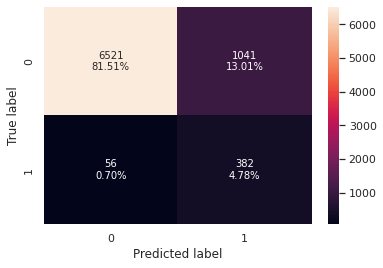

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(log_reg_under, X_val, y_val)

### Ada Boost on undersampled data

In [ ]:
abc_reg_under = AdaBoostClassifier(random_state=1)
abc_reg_under.fit(X_train_un, y_train_un)

AdaBoostClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
abc_reg_under_train_perf = model_performance_classification_sklearn(
    abc_reg_under, X_train_un, y_train_un
)
print("Training performance:")
abc_reg_under_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.908,0.894,0.920,0.907,0.832


In [ ]:
# Calculating different metrics on validation set
abc_reg_under_val_perf = model_performance_classification_sklearn(
    abc_reg_under, X_val, y_val
)
print("Validation performance:")
abc_reg_under_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.883,0.895,0.306,0.457,0.541


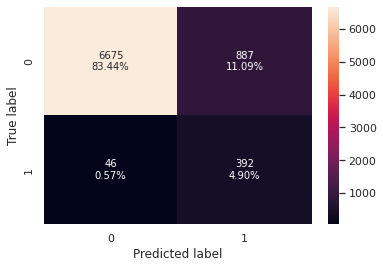

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(abc_reg_under, X_val, y_val)

* Model still overfitting in both training and validation

### Gradient Boost undersampled data

In [ ]:
gbc_reg_under = GradientBoostingClassifier(random_state=1)
gbc_reg_under.fit(X_train_un, y_train_un)

GradientBoostingClassifier(random_state=1)

In [ ]:
# Calculating different metrics on train set
gbc_reg_under_train_perf = model_performance_classification_sklearn(
    gbc_reg_under, X_train_un, y_train_un
)
print("Training performance:")
gbc_reg_under_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.957,0.925,0.988,0.956,0.886


In [ ]:
# Calculating different metrics on validation set
gbc_reg_under_val_perf = model_performance_classification_sklearn(
    gbc_reg_under, X_val, y_val
)
print("Validation performance:")
gbc_reg_under_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.939,0.904,0.470,0.618,0.667


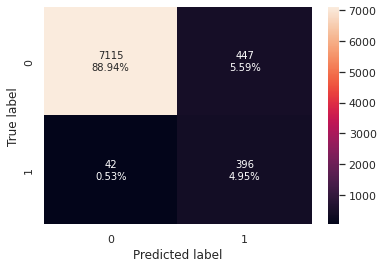

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(gbc_reg_under, X_val, y_val)

* Model performing well in training as compared to validation model

### XGBoost undersampled data

In [ ]:
xgb_reg_under = XGBClassifier(random_state=1,eval_metric='logloss')
xgb_reg_under.fit(X_train_un, y_train_un)

XGBClassifier(eval_metric='logloss', random_state=1)

In [ ]:
# Calculating different metrics on train set
xgb_reg_under_train_perf = model_performance_classification_sklearn(
    xgb_reg_under, X_train_un, y_train_un
)
print("Training performance:")
xgb_reg_under_train_perf

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.954,0.918,0.990,0.953,0.877


In [ ]:
# Calculating different metrics on validation set
xgb_reg_under_val_perf = model_performance_classification_sklearn(
    xgb_reg_under, X_val, y_val
)
print("Validation performance:")
xgb_reg_under_val_perf

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.945,0.906,0.501,0.645,0.686


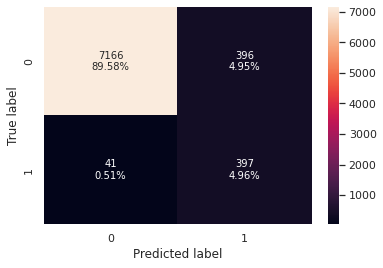

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(xgb_reg_under, X_val, y_val)

Model still overfitting

## Model Selection

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
     decision_tree_perf_train.T,
        dtree_reg_over_train_perf.T,
         dtree_reg_under_train_perf.T,
     rf_estimator_model_train_perf.T,
        rf_reg_over_train_perf.T,
         rf_reg_under_train_perf.T,
     bagging_classifier_model_train_perf.T,
        bg_reg_over_train_perf.T,
         bg_reg_under_train_perf.T,
           log_reg_model_train_perf.T,
        log_reg_over_train_perf.T,
         log_reg_under_train_perf.T,
     abc_model_train_perf.T,
        ab_reg_over_train_perf.T,
         abc_reg_under_train_perf.T,
     gbc_model_train_perf.T,
        gbc_reg_over_train_perf.T,
         gbc_reg_under_train_perf.T,
     xgb_model_train_perf.T,
        xgb_reg_over_train_perf.T,
         xgb_reg_under_train_perf.T,
     
     
    ],
    axis=1,
)
models_train_comp_df.columns = [
                                 "Decision Tree",
    "Decision Tree with oversampled data",
       "Decision Tree with undersampled data",
                                        "Random Forest",
    "Random Forest with oversampled data",
       "Random Forest with undersampled data",
           "Bagging Classifier",
    "Bagging Classifier with oversampled data",
       "Bagging Classifier with undersampled data",
                         "Logistic Regression",
    "Logistic Regression with oversampled data",
       "Logistic Regression with undersampled data",
       "Ada Boost",
    "Ada Boost with oversampled data",
       "Ada Boost with undersampled data",
         "Gradient Boost",
    "Gradient Boost with oversampled data",
       "Gradient Boost with undersampled data",
         "XGBoost",
    "XG Boost with oversampled data",
       "XG Boost with undersampled data",
          
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree with oversampled data,Decision Tree with undersampled data,Random Forest,Random Forest with oversampled data,Random Forest with undersampled data,Bagging Classifier,Bagging Classifier with oversampled data,Bagging Classifier with undersampled data,Logistic Regression,Logistic Regression with oversampled data,Logistic Regression with undersampled data,Ada Boost,Ada Boost with oversampled data,Ada Boost with undersampled data,Gradient Boost,Gradient Boost with oversampled data,Gradient Boost with undersampled data,XGBoost,XG Boost with oversampled data,XG Boost with undersampled data
Accuracy,1.000,1.000,1.000,1.000,1.000,1.000,0.997,0.999,0.990,0.967,0.872,0.862,0.976,0.906,0.908,0.987,0.949,0.957,0.989,0.947,0.954
Recall,1.000,1.000,1.000,0.999,1.000,1.000,0.950,0.999,0.982,0.478,0.874,0.856,0.625,0.892,0.894,0.779,0.925,0.925,0.805,0.921,0.918
Precision,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,0.998,0.857,0.871,0.867,0.900,0.918,0.920,0.978,0.971,0.988,0.985,0.972,0.990
F1,1.000,1.000,1.000,1.000,1.000,1.000,0.974,0.999,0.990,0.614,0.872,0.861,0.738,0.905,0.907,0.867,0.947,0.956,0.886,0.946,0.953
Minimum_Vs_Model_cost,1.000,1.000,1.000,0.999,1.000,1.000,0.922,0.998,0.971,0.527,0.798,0.779,0.607,0.829,0.832,0.728,0.882,0.886,0.752,0.876,0.877


In [ ]:
# # Validation performance comparison

models_train_comp_df = pd.concat(
    [
     decision_tree_val_test.T,
        dtree_reg_over_val_perf.T,
         dtree_reg_under_val_perf.T,
     rf_estimator_model_val_perf.T,
        rf_reg_over_val_perf.T,
         rf_reg_under_val_perf.T,
     bagging_classifier_model_val_perf.T,
        bg_reg_over_val_perf.T,
         bg_reg_under_val_perf.T,
           log_reg_model_val_perf.T,
        log_reg_over_val_perf.T,
         log_reg_under_val_perf.T,
     abc_model_val_perf.T,
        ab_reg_over_val_perf.T,
         abc_reg_under_val_perf.T,
    gbc_model_val_perf.T,
        gbc_reg_over_val_perf.T,
         gbc_reg_under_val_perf.T,
     xgb_model_val_perf.T,
        xgb_reg_over_val_perf.T,
         xgb_reg_under_val_perf.T,
     
     
    ],
    axis=1,
)
models_train_comp_df.columns = [
                                 "Decision Tree",
    "Decision Tree with oversampled data",
       "Decision Tree with undersampled data",
                                        "Random Forest",
    "Random Forest with oversampled data",
       "Random Forest with undersampled data",
           "Bagging Classifier",
    "Bagging Classifier with oversampled data",
       "Bagging Classifier with undersampled data",
                         "Logistic Regression",
    "Logistic Regression with oversampled data",
       "Logistic Regression with undersampled data",
       "Ada Boost",
    "Ada Boost with oversampled data",
       "Ada Boost with undersampled data",
         "Gradient Boost",
    "Gradient Boost with oversampled data",
       "Gradient Boost with undersampled data",
         "XGBoost",
    "XG Boost with oversampled data",
       "XG Boost with undersampled data",
          
]
print("Validation performance comparison:")
models_train_comp_df

Validation performance comparison:


,Decision Tree,Decision Tree with oversampled data,Decision Tree with undersampled data,Random Forest,Random Forest with oversampled data,Random Forest with undersampled data,Bagging Classifier,Bagging Classifier with oversampled data,Bagging Classifier with undersampled data,Logistic Regression,Logistic Regression with oversampled data,Logistic Regression with undersampled data,Ada Boost,Ada Boost with oversampled data,Ada Boost with undersampled data,Gradient Boost,Gradient Boost with oversampled data,Gradient Boost with undersampled data,XGBoost,XG Boost with oversampled data,XG Boost with undersampled data
Accuracy,0.970,0.949,0.847,0.988,0.989,0.961,0.985,0.980,0.950,0.967,0.868,0.863,0.974,0.915,0.883,0.983,0.960,0.939,0.987,0.960,0.945
Recall,0.776,0.820,0.884,0.795,0.879,0.902,0.774,0.833,0.879,0.523,0.863,0.872,0.623,0.884,0.895,0.751,0.904,0.904,0.788,0.895,0.906
Precision,0.700,0.523,0.248,0.986,0.917,0.591,0.947,0.808,0.524,0.798,0.275,0.268,0.869,0.380,0.306,0.932,0.589,0.470,0.969,0.590,0.501
F1,0.736,0.639,0.388,0.880,0.897,0.714,0.852,0.820,0.656,0.632,0.417,0.411,0.726,0.531,0.457,0.832,0.714,0.618,0.869,0.711,0.645
Minimum_Vs_Model_cost,0.674,0.645,0.480,0.743,0.814,0.729,0.719,0.744,0.681,0.544,0.503,0.499,0.603,0.597,0.541,0.698,0.730,0.667,0.734,0.724,0.686


* Decision tree on training performing well as compared to other models 
* Random Forest with Over sampled data performs well on training as compared to validation.
* Bagging Classifier with over sampled data performs well on training set.
* Logistic Regressionperforming better on validation set

## HyperparameterTuning 

- **Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

#### For XGBoost:
param_grid={'n_estimators':np.arange(150,300,50),'scale_pos_weight':[5,10],
            'learning_rate':[0.1,0.2], 'gamma':[0,3,5],
            'subsample':[0.8,0.9]}

#### For Gradient Boosting:
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]}


#### For Adaboost:
param_grid = {
    "n_estimators": np.arange(10, 110, 20),
    "learning_rate": [ 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1)]}

#### For logistic Regression:
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#### For Bagging Classifier:
param_grid = {
              'max_samples': [0.8,0.9], 
              'max_features': [0.8,0.9],
              'n_estimators' : [40,50]}

#### For Random Forest:
param_grid = {
    "n_estimators": [150,250],
    "min_samples_leaf": np.arange(1, 3),
    "max_features": ['sqrt','log2'],
    "max_samples": np.arange(0.2, 0.6, 0.1)}

#### For Decision Trees:
param_grid = {'max_depth': np.arange(2,20), 
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001]
             }

### Grid Search CV

## Decision Tree

In [ ]:
# Creating pipeline
model2 = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV
param_grid = {
    "max_leaf_nodes":[5, 10,15],
    "max_depth": np.arange(2,20),
    "min_samples_split": [1, 2, 5, 7],
    "min_impurity_decrease": [0.0001,0.001],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Run the grid search
grid_obj = GridSearchCV(model, param_grid, scoring=scorer)
grid_obj.fit(X_val, y_val)

# Set the clf to the best combination of parameters
model2= grid_obj.best_estimator_

# Fit the best algorithm to the data.
model2.fit(X_val, y_val)




DecisionTreeClassifier(max_depth=8, max_leaf_nodes=15,
                       min_impurity_decrease=0.0001, random_state=1)

In [ ]:
# Calculating different metrics on train set
dtree_grid_train = model_performance_classification_sklearn(
    model2, X_train, y_train
)
print("Training performance:")
dtree_grid_train



Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.975,0.626,0.883,0.732,0.606


In [ ]:
# Calculating different metrics on validation set
dtree_grid_val = model_performance_classification_sklearn(
    model2, X_val, y_val
)
print("Validation performance:")
dtree_grid_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.974,0.646,0.847,0.733,0.614


## Random Forest

In [ ]:
# Choose the type of classifier.
rf_estimator1=RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
param_grid = { "n_estimators": [150,250], "min_samples_leaf": np.arange(1, 3), "max_features": ['sqrt','log2'], "max_samples": np.arange(0.2, 0.6, 0.1)}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator1, param_grid, scoring=scorer)
grid_obj = grid_obj.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
rf_estimator1 = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_estimator1.fit(X_train_over, y_train_over)

RandomForestClassifier(max_features='sqrt', max_samples=0.5000000000000001,
                       n_estimators=250, random_state=1)

In [ ]:
# Calculating different metrics on train set
rf_grid_train = model_performance_classification_sklearn(
    rf_estimator1, X_train_over, y_train_over
)
print("Training performance:")
rf_grid_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.999,0.998,1.000,0.999,0.997


In [ ]:
# Calculating different metrics on validation set
rf_grid_val = model_performance_classification_sklearn(
    rf_estimator1, X_val, y_val
)
print("validation performance:")
rf_grid_val

validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.988,0.877,0.899,0.888,0.808


## Logistic Regression

In [ ]:
# Choose the type of classifier.
lr_estimator1 = LogisticRegression(random_state=1, solver="saga")

# Grid of parameters to choose from
parameters = {"C": np.arange(0.1, 1.1, 0.1)}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Run the grid search
grid_obj = GridSearchCV(lr_estimator1, parameters, scoring=scorer)
grid_obj = grid_obj.fit(X_val, y_val)

# Set the clf to the best combination of parameters
lr_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
lr_estimator1.fit(X_val, y_val)

LogisticRegression(random_state=1, solver='saga')

In [ ]:
# Calculating different metrics on train set
lr_grid_train = model_performance_classification_sklearn(
    lr_estimator1, X_train, y_train
)
print("Training performance:")
lr_grid_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.966,0.448,0.875,0.593,0.515


In [ ]:
# Calculating different metrics on validation set
lr_grid_val = model_performance_classification_sklearn(
    lr_estimator1, X_val, y_val
)
print("validation performance:")
lr_grid_val

validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.967,0.489,0.846,0.619,0.531


## XGBoost

In [ ]:
#defining model
model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in GridSearchCV
param_grid={'n_estimators':np.arange(150,300,50),'scale_pos_weight':[5,10], 'learning_rate':[0.1,0.2], 'gamma':[0,3,5], 'subsample':[0.8,0.9]}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Run the grid search
grid_obj = GridSearchCV(model,param_grid, scoring=scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
model = grid_obj.best_estimator_

# Fit the best algorithm to the data.
model.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', gamma=5, learning_rate=0.2,
              n_estimators=250, random_state=1, scale_pos_weight=10,
              subsample=0.9)

In [ ]:
# Creating new pipeline with best parameters
xgb_tuned2 = XGBClassifier(random_state=1,eval_metric='logloss',estimators=200,
              scale_pos_weight=5, subsample=0.8)


# Fit the model on training data
xgb_tuned2 .fit(X_train, y_train)

XGBClassifier(estimators=200, eval_metric='logloss', random_state=1,
              scale_pos_weight=5, subsample=0.8)

In [ ]:
# Calculating different metrics on train set
xgboost_grid_train = model_performance_classification_sklearn(
    xgb_tuned2, X_train, y_train
)
print("Training performance:")
xgboost_grid_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.997,0.999,0.955,0.977,0.983


In [ ]:
# Calculating different metrics on validation set
xgboost_grid_val = model_performance_classification_sklearn(
    xgb_tuned2, X_val, y_val
)
print("Validation performance:")
xgboost_grid_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.988,0.881,0.894,0.887,0.811


### RandomizedSearchCV

### Decision Tree

In [ ]:
# Creating pipeline
model = DecisionTreeClassifier(random_state=1)

param_grid = {
    "max_leaf_nodes":[5, 10,15],
    "max_depth": np.arange(2,20),
    "min_samples_split": [1, 2, 5, 7],
    "min_impurity_decrease": [0.0001,0.001],
}
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'min_samples_split': 2, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 8} with CV score=0.5864455053889276:


In [ ]:
# Creating new pipeline with best parameters
dtree_tuned2 = DecisionTreeClassifier(
    random_state=1, min_samples_split=2, min_impurity_decrease=0.0001, max_leaf_nodes=15, max_depth= 8
)

# Fit the model on training data
dtree_tuned2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, max_leaf_nodes=15,
                       min_impurity_decrease=0.0001, random_state=1)

In [ ]:
# Calculating different metrics on train set
dtree_random_train = model_performance_classification_sklearn(
    dtree_tuned2, X_train, y_train
)
print("Training performance:")
dtree_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.975,0.626,0.883,0.732,0.606


In [ ]:
# Calculating different metrics on validation set
dtree_random_val = model_performance_classification_sklearn(dtree_tuned2, X_val, y_val)
print("Validation performance:")
dtree_random_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.974,0.646,0.847,0.733,0.614


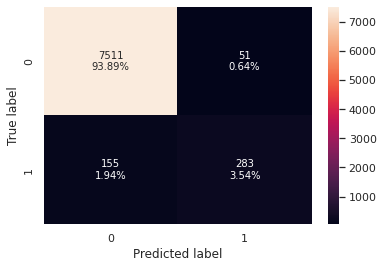

In [ ]:
# creating confusion matrix
confusion_matrix_sklearn(dtree_tuned2, X_val, y_val)

### Random Forest

In [ ]:
# Creating pipeline
# Choose the type of classifier.
model =RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
param_grid = { "n_estimators": [150,250], "min_samples_leaf": np.arange(1, 3), "max_features": ['sqrt','log2'], "max_samples": np.arange(0.2, 0.6, 0.1)}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring=scorer,
    cv=5,
    random_state=1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.5000000000000001, 'max_features': 'sqrt'} with CV score=0.6825213208832247:


In [ ]:
# Creating new pipeline with best parameters
rf_tuned2 = RandomForestClassifier(
    random_state=1, n_estimators=250, min_samples_leaf=1, max_samples=0.5000000000000001, max_features='sqrt'
)

# Fit the model on training data
rf_tuned2.fit(X_train_over, y_train_over)

RandomForestClassifier(max_features='sqrt', max_samples=0.5000000000000001,
                       n_estimators=250, random_state=1)

In [ ]:
# Calculating different metrics on train set
rf_random_train = model_performance_classification_sklearn(
    rf_tuned2, X_train, y_train
)
print("Training performance:")
rf_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,1.000,1.000,0.997,0.998,0.999


In [ ]:
# Calculating different metrics on validation set
rf_random_val = model_performance_classification_sklearn(rf_tuned2, X_val, y_val)
print("Validation performance:")
rf_random_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.988,0.877,0.899,0.888,0.808


### XGBoost

In [ ]:
%%time 

#defining model
model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in GridSearchCV
param_grid={'n_estimators':np.arange(150,300,50),'scale_pos_weight':[5,10], 'learning_rate':[0.1,0.2], 'gamma':[0,3,5], 'subsample':[0.8,0.9]}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

#Calling RandomizedSearchCV
xgb_tuned2 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
xgb_tuned2.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(xgb_tuned2.best_params_,xgb_tuned2.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 3} with CV score=0.8027595210699092:
CPU times: user 31.5 s, sys: 2.05 s, total: 33.6 s
Wall time: 36min 53s


In [ ]:
# Creating new pipeline with best parameters
xgb_tuned2 = XGBClassifier(random_state=1,eval_metric='logloss',gamma=3, learning_rate=0.2, n_estimators=250, scale_pos_weight=10, subsample=0.9)


# Fit the model on training data
xgb_tuned2.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', gamma=3, learning_rate=0.2,
              n_estimators=250, random_state=1, scale_pos_weight=10,
              subsample=0.9)

In [ ]:
# Calculating different metrics on train set
xgboost_random_train = model_performance_classification_sklearn(
    xgb_tuned2, X_train, y_train
)
print("Training performance:")
xgboost_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.997,0.999,0.955,0.977,0.983


In [ ]:
# Calculating different metrics on validation set
xgboost_random_val = model_performance_classification_sklearn(
    xgb_tuned2, X_val, y_val
)
print("Validation performance:")
xgboost_random_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.988,0.881,0.894,0.887,0.811


### Logistic Regression

In [ ]:
# Choose the type of classifier.
lr_estimator2 = LogisticRegression(random_state=1, solver="saga")

# Grid of parameters to choose from
parameters = {"C": np.arange(0.1, 1.1, 0.1)}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

#Calling RandomizedSearchCV
lr_estimator2 = RandomizedSearchCV(estimator=model, param_distributions=parameters, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
lr_estimator2.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(lr_estimator2.best_params_,lr_estimator2.best_score_))



Best parameters are {'C': 0.1} with CV score=0.697473393618169:


In [ ]:
# Creating new pipeline with best parameters
lr_tuned2 = LogisticRegression(random_state=1, solver="saga",C=0.1)


# Fit the model on training data
lr_tuned2 .fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=1, solver='saga')

In [ ]:
# Calculating different metrics on train set
lr_random_train = model_performance_classification_sklearn(
    lr_tuned2, X_train, y_train
)
print("Training performance:")
lr_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.967,0.478,0.857,0.614,0.527


In [ ]:
# Calculating different metrics on validation set
lr_random_val = model_performance_classification_sklearn(
    lr_tuned2, X_val, y_val
)
print("validation performance:")
lr_random_val

validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.967,0.523,0.798,0.632,0.544


## Model Performance comparison and choosing the final model

### Comparing models from GridsearchCV and RandomisedsearchCV

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        dtree_grid_train.T,
        dtree_random_train.T,
     rf_grid_train.T,
     rf_random_train.T,
     lr_grid_train.T,
     lr_random_train.T,
        xgboost_grid_train.T,
        xgboost_random_train.T,
     
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree Tuned with Grid search",
    "Decision Tree Tuned with Random search",
      "Random Forest Tuned with Grid search",
    "Random Forest Tuned with Random search",
      "Logistic Regression Tuned with Grid search",
    "Logistic Tuned with Random search",
    "Xgboost Tuned with Grid search",
    "Xgboost Tuned with Random Search",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree Tuned with Grid search,Decision Tree Tuned with Random search,Random Forest Tuned with Grid search,Random Forest Tuned with Random search,Logistic Regression Tuned with Grid search,Logistic Tuned with Random search,Xgboost Tuned with Grid search,Xgboost Tuned with Random Search
Accuracy,0.975,0.975,0.999,1.000,0.966,0.967,0.997,0.997
Recall,0.626,0.626,0.998,1.000,0.448,0.478,0.999,0.999
Precision,0.883,0.883,1.000,0.997,0.875,0.857,0.955,0.955
F1,0.732,0.732,0.999,0.998,0.593,0.614,0.977,0.977
Minimum_Vs_Model_cost,0.606,0.606,0.997,0.999,0.515,0.527,0.983,0.983


In [ ]:
# validation performance comparison

models_train_comp_df = pd.concat(
    [
        dtree_grid_val.T,
        dtree_random_val.T,
     rf_grid_val.T,
     rf_random_val.T,
     lr_grid_val.T,
     lr_random_val.T,
        xgboost_grid_val.T,
        xgboost_random_val.T,
     
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree Tuned with Grid search",
    "Decision Tree Tuned with Random search",
      "Random Forest Tuned with Grid search",
    "Random Forest Tuned with Random search",
      "Logistic Regression Tuned with Grid search",
    "Logistic Tuned with Random search",
    "Xgboost Tuned with Grid search",
    "Xgboost Tuned with Random Search",
]
print("validation performance comparison:")
models_train_comp_df

validation performance comparison:


,Decision Tree Tuned with Grid search,Decision Tree Tuned with Random search,Random Forest Tuned with Grid search,Random Forest Tuned with Random search,Logistic Regression Tuned with Grid search,Logistic Tuned with Random search,Xgboost Tuned with Grid search,Xgboost Tuned with Random Search
Accuracy,0.974,0.974,0.988,0.988,0.967,0.967,0.988,0.988
Recall,0.646,0.646,0.877,0.877,0.489,0.523,0.881,0.881
Precision,0.847,0.847,0.899,0.899,0.846,0.798,0.894,0.894
F1,0.733,0.733,0.888,0.888,0.619,0.632,0.887,0.887
Minimum_Vs_Model_cost,0.614,0.614,0.808,0.808,0.531,0.544,0.811,0.811


* We can see that XGBoost is giving a similar performance with GridSearchCV and RandomizedSearchCV on Training Performance COmparisson and validation comparison.
* XGBoost gives the best results among the models

## Test set final performance

In [ ]:
# Calculating different metrics on the test set
xgboost_grid_test = model_performance_classification_sklearn(xgb_tuned2, X_test, y_test)
print("Test performance:")
xgboost_grid_test

Test performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.988,0.870,0.911,0.890,0.803


The performance on test data is generalised

## Pipelines to build the final model


In [ ]:
# Use Local drives to upload the csv on google colab
from google.colab import files
uploaded = files.upload()

Saving Test.csv to Test.csv


In [ ]:
# Loading the dataset
data = pd.read_csv(io.BytesIO(uploaded['Test.csv']))

In [ ]:
# Checking the number of rows and columns in the data
data.shape

(10000, 41)

In [ ]:
# Separating target variable and other variables
X = data.drop("Target", axis=1)
Y = data["Target"]

In [ ]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=1, stratify=Y
)
print(X_train.shape, X_test.shape)

(9000, 40) (1000, 40)


In [ ]:
values = data.values
X = values[:,0:40]
y = values[:,40]

# fill missing values with mean column values
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

transformed_X = numeric_transformer.fit_transform(X) 



In [ ]:
# Creating new pipeline with best parameters
model = Pipeline(
    steps=[
        ("pre", numeric_transformer),
        (
            "XGB",
            XGBClassifier(
                random_state=1,
                n_estimators=250,
                scale_pos_weight=10,
                subsample=0.9,
                learning_rate=0.05,
                gamma=3,
                eval_metric='logloss',
                         ),
        ),
    ]
)
# Fit the model on training data
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='median'))])),
                ('XGB',
                 XGBClassifier(eval_metric='logloss', gamma=3,
                               learning_rate=0.05, n_estimators=250,
                               random_state=1, scale_pos_weight=10,
                               subsample=0.9))])

In [ ]:
# transforming and predicting on test data
model.predict(X_test)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Business Insights and Conclusions

* Outliers seems to be clipped on the data and they need to be investigated as they may have an impact on the decisions to be made.
* Data collection by the sensors is also affected by various environmental factors (temperature, humidity, wind speed, etc.). These are natural occurances and the model can be improved further if we also had further information like days and hours that various readings are taken.Maybe in the morning there could be a lot of recordings on sensors than evening due to wind changes.
* Information on date of purchase of some of the machines would be important to appreciate the depreciation level of different machines as some could increase maintanance cost due to longer life spans.
* Negative sensor readings needs to be investigated further as some sensors have extreme negative values